In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import nltk
from nltk.corpus import stopwords

from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression

from nltk.tokenize import word_tokenize 

import re
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("BBC News.csv")

In [3]:
df.head()

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


In [4]:
df['Category'].unique()

array(['business', 'tech', 'politics', 'sport', 'entertainment'],
      dtype=object)

In [5]:
df.shape

(1490, 3)

In [6]:
df.dtypes

ArticleId     int64
Text         object
Category     object
dtype: object

In [7]:
df.isnull().any()

ArticleId    False
Text         False
Category     False
dtype: bool

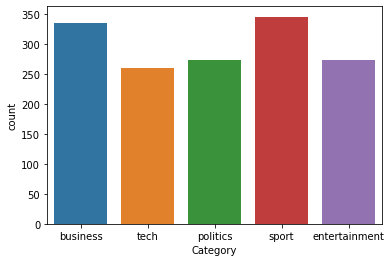

In [8]:
sns.countplot(df.Category)


Removing Punctuations and Stopwords

In [9]:
def clean(text):
    text = text.lower().replace('\n',' ').replace('\r','').strip()
    text = re.sub(' +', ' ', text)
    text = re.sub(r'[^\w\s]','',text)
    
    
    stop_words = set(stopwords.words('english')) 
    word_tokens = word_tokenize(text) 
    filtered_sentence = [w for w in word_tokens if not w in stop_words] 
    filtered_sentence = [] 
    for w in word_tokens: 
        if w not in stop_words: 
            filtered_sentence.append(w) 
    
    text = " ".join(filtered_sentence)
    return text

In [10]:
df['p_text'] = df['Text'].apply(clean)

In [11]:
df.head()

,ArticleId,Text,Category,p_text
0,1833,worldcom ex-boss launches defence lawyers defe...,business,worldcom exboss launches defence lawyers defen...
1,154,german business confidence slides german busin...,business,german business confidence slides german busin...
2,1101,bbc poll indicates economic gloom citizens in ...,business,bbc poll indicates economic gloom citizens maj...
3,1976,lifestyle governs mobile choice faster bett...,tech,lifestyle governs mobile choice faster better ...
4,917,enron bosses in $168m payout eighteen former e...,business,enron bosses 168m payout eighteen former enron...


In [12]:
from sklearn import preprocessing 
label_encoder = preprocessing.LabelEncoder() 
df['label']= label_encoder.fit_transform(df['Category']) 

In [13]:
X_train, X_test, y_train, y_test = train_test_split(df['p_text'], 
                                                    df['label'], 
                                                    test_size=0.33, 
                                                    random_state=21)

In [14]:
X_train

54      calder fears scottish rugby former scotland in...
1454    mayor retract nazi jibe london mayor ken livin...
362     china suspends 26 power projects china ordered...
1209    defiant hunts put ban test thousands hunt supp...
131     call centre users lose patience customers tryi...
                              ...                        
368     china net cafe culture crackdown chinese autho...
48      halo 2 sells five million copies microsoft cel...
772     act detention ruling uk urged government must ...
1231    wenger steps row arsene wenger stepped feud si...
969     civil servants strike ballot uk biggest civil ...
Name: p_text, Length: 998, dtype: object

In [15]:
tfidf = TfidfVectorizer(encoding='utf-8',
                        ngram_range=(1,2),
                        stop_words=None,
                        lowercase=False,
                        max_df=1.0,
                        min_df=10,
                        max_features=300,
                        norm='l2',
                        sublinear_tf=True)
                        
features_train = tfidf.fit_transform(X_train).toarray()
labels_train = y_train
print(features_train)

features_test = tfidf.transform(X_test).toarray()
labels_test = y_test
print(features_test.shape)





[[0.         0.14254248 0.         ... 0.08351994 0.         0.11125003]
 [0.         0.         0.         ... 0.12242773 0.         0.09631525]
 [0.         0.         0.11633011 ... 0.10001772 0.13675333 0.        ]
 ...
 [0.         0.         0.         ... 0.11401833 0.05993299 0.        ]
 [0.07749327 0.09037755 0.         ... 0.05295493 0.         0.        ]
 [0.2525512  0.         0.         ... 0.         0.         0.09633361]]
(492, 300)


In [16]:
model = LogisticRegression()
print(model.get_params())
model.fit(features_train, labels_train)
model_predictions = model.predict(features_test)
print('Accuracy: ', accuracy_score(labels_test, model_predictions))
print(classification_report(labels_test, model_predictions))

{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Accuracy:  0.9308943089430894
              precision    recall  f1-score   support

           0       0.87      0.95      0.91       108
           1       0.96      0.91      0.94        90
           2       0.93      0.94      0.94        86
           3       0.96      0.97      0.96       127
           4       0.95      0.85      0.90        81

    accuracy                           0.93       492
   macro avg       0.93      0.93      0.93       492
weighted avg       0.93      0.93      0.93       492



In [17]:
from sklearn.model_selection import GridSearchCV

In [18]:
param_grid = {'C': [0.1,0.001,1],
    # Create a list of options for the regularization penalty
    'penalty' : ['l1', 'l2'] }
clf = GridSearchCV(model, param_grid, cv = 3, verbose = 1)

bestF = clf.fit(features_train, labels_train)
bestF.best_params_

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    0.2s finished


{'C': 1, 'penalty': 'l2'}

In [19]:
model = LogisticRegression(C=1)
model.fit(features_train, labels_train)
model_predictions = model.predict(features_test)
print('Accuracy: ', accuracy_score(labels_test, model_predictions))
print(classification_report(labels_test, model_predictions))

Accuracy:  0.9308943089430894
              precision    recall  f1-score   support

           0       0.87      0.95      0.91       108
           1       0.96      0.91      0.94        90
           2       0.93      0.94      0.94        86
           3       0.96      0.97      0.96       127
           4       0.95      0.85      0.90        81

    accuracy                           0.93       492
   macro avg       0.93      0.93      0.93       492
weighted avg       0.93      0.93      0.93       492

